In [1]:
import sys 
from pathlib import Path
import tensorflow as tf
import pandas as pd
import numpy as np 
import keras

module_path = str(Path.cwd().parents[0]/'Encoder')
if module_path not in sys.path:
    sys.path.append(module_path)

from Encoder import Encoder

file_path = "C:\\Users\\nvanb\\Documents\\Master\\1_Masterstage\\master_stage\\Float_data\\Float_data_10000_events_10_values_at_20240319143349.csv"

In [2]:
def train_val_test_split(df):
    # np.split() to split the dataset
    # train_znorm.sample(frac=1, random_state=42) to shuffle the dataset random
    # [int(.6*len(train_znorm)),int(.8*len(train_znorm))] first split after 60% of the data. second split after 80%
    # 60% train set - 20% validation set - 20% test set
    df_train, df_validate, df_test = np.split(df.sample(frac=1, random_state=42), [int(.6*len(df)),int(.8*len(df))])
    return df_train, df_validate, df_test

def define_targets_and_features(df): 
    """Function defines the features and targets of a dataframe,
    The targets are in the last column of the dataframe; the features are in the other columns"""
    
    features, targets = df.keys()[0:-2], df.keys()[2:]
    return features, targets

In [3]:
df_data = pd.DataFrame(pd.read_csv(file_path))
df_data = df_data.astype(int)

# Make train, validation and test split
df_train, df_validate, df_test = train_val_test_split(df_data)

# Store test to .csv file
df_test.to_csv("C:\\Users\\nvanb\\Documents\\Master\\1_Masterstage\\master_stage\\Float_data\\fixed_length_testdata.csv")


# Define targets and features
features, targets = define_targets_and_features(df_data)
train_features = df_train[features]
train_targets = df_train[targets]
validate_features = df_validate[features]
validate_targets = df_validate[targets]

In [4]:
d_model = int(512/4)
d_ff = 2048
batch_size = 64
h = 8 
n = 6
d_k = int(d_model/h)
d_v = int(d_model/h)
rate = 0.1

n_events = df_data.shape[0]
vocab_size = int(np.max(np.max(df_data), axis=0)+1) # add one because we include 0

padding_mask = None
seq_length = len(df_data.columns)+vocab_size
print(vocab_size)
print(seq_length)
print(d_k)


31
41
16


c:\Users\nvanb\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


In [5]:
# Define the loss function and optimizer
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#loss_function = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=2), keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2)]

In [6]:
encoder_model = Encoder(batch_size, seq_length, h, n, d_model, d_ff, d_k, d_v, rate, vocab_size, d_model, padding_mask, training=True)
encoder_model.build(input_shape=(n_events, seq_length))
encoder_model.summary()

Tensor("position_embedding_fixed_weights/add:0", shape=(10000, 41, 128), dtype=float32)
Tensor("layer_normalization_1/add:0", shape=(10000, 41, 128), dtype=float32)
Tensor("layer_normalization_3/add:0", shape=(10000, 41, 128), dtype=float32)
Tensor("layer_normalization_5/add:0", shape=(10000, 41, 128), dtype=float32)
Tensor("layer_normalization_7/add:0", shape=(10000, 41, 128), dtype=float32)
Tensor("layer_normalization_9/add:0", shape=(10000, 41, 128), dtype=float32)
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 position_embedding_fixed_we  multiple                 20352     
 ights (PositionEmbeddingFix                                     
 edWeights)                                                      
                                                                 
 encoder_layer (EncoderLayer  multiple                 0 (unused)
 )                                              

In [7]:
num_epochs = 5
encoder_model.compile(optimizer, loss=loss_function, metrics='accuracy')
history = encoder_model.fit(train_features, train_targets, batch_size=batch_size, epochs=num_epochs, validation_data=(validate_features, validate_targets), callbacks=callbacks)

encoder_model.save_weights("C:\\Users\\nvanb\\Documents\\Master\\1_Masterstage\\master_stage\\Coordinates_data\\model_fixedlen.keras")

Epoch 1/5
Tensor("encoder/position_embedding_fixed_weights/add:0", shape=(None, 8, 128), dtype=float32)
Tensor("encoder/layer_normalization_1/add:0", shape=(None, 8, 128), dtype=float32)
Tensor("encoder/layer_normalization_3/add:0", shape=(None, 8, 128), dtype=float32)
Tensor("encoder/layer_normalization_5/add:0", shape=(None, 8, 128), dtype=float32)
Tensor("encoder/layer_normalization_7/add:0", shape=(None, 8, 128), dtype=float32)
Tensor("encoder/layer_normalization_9/add:0", shape=(None, 8, 128), dtype=float32)
Tensor("encoder/position_embedding_fixed_weights/add:0", shape=(None, 8, 128), dtype=float32)
Tensor("encoder/layer_normalization_1/add:0", shape=(None, 8, 128), dtype=float32)
Tensor("encoder/layer_normalization_3/add:0", shape=(None, 8, 128), dtype=float32)
Tensor("encoder/layer_normalization_5/add:0", shape=(None, 8, 128), dtype=float32)
Tensor("encoder/layer_normalization_7/add:0", shape=(None, 8, 128), dtype=float32)
Tensor("encoder/layer_normalization_9/add:0", shape=(No

In [10]:
epoch_history = [_ for _ in range (0,num_epochs)]
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']

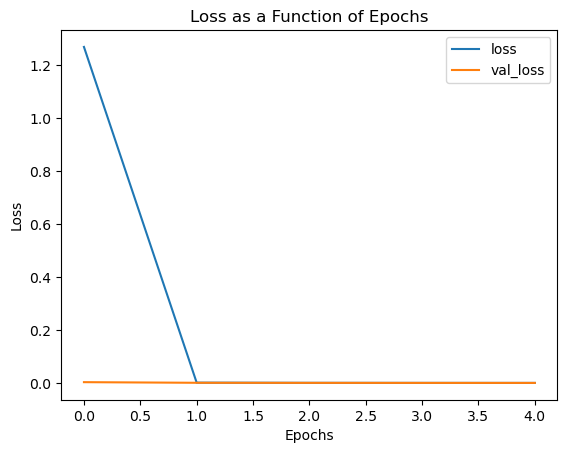

In [11]:
import matplotlib.pyplot as plt

plt.plot(epoch_history, loss_history, label='loss')
plt.plot(epoch_history, val_loss_history, label='val_loss')
plt.title('Loss as a Function of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
validate_features

0   1   2   3   4   5   6   7
2480  2   5   7  10  12  15  17  20
289   2   5   7  10  12  15  17  20
6086  0   2   5   7  10  12  15  17
3075  2   5   7  10  12  15  17  20
8123  7  10  12  15  17  20  22  25
...  ..  ..  ..  ..  ..  ..  ..  ..
1638  2   5   7  10  12  15  17  20
5891  2   5   7  10  12  15  17  20
7427  2   5   7  10  12  15  17  20
608   7  10  12  15  17  20  22  25
6907  7  10  12  15  17  20  22  25

[2000 rows x 8 columns]

In [13]:
validate_targets

2   3   4   5   6   7   8   9
2480   7  10  12  15  17  20  22  25
289    7  10  12  15  17  20  22  25
6086   5   7  10  12  15  17  20  22
3075   7  10  12  15  17  20  22  25
8123  12  15  17  20  22  25  27  30
...   ..  ..  ..  ..  ..  ..  ..  ..
1638   7  10  12  15  17  20  22  25
5891   7  10  12  15  17  20  22  25
7427   7  10  12  15  17  20  22  25
608   12  15  17  20  22  25  27  30
6907  12  15  17  20  22  25  27  30

[2000 rows x 8 columns]

In [34]:
validate_targets.iloc[:,-2]

2480    22
289     22
6086    20
3075    22
8123    27
        ..
1638    22
5891    22
7427    22
608     27
6907    27
Name: 8, Length: 2000, dtype: int32

In [50]:
validate_targets.iloc[:,-2:-1].reset_index(drop=True)

8
0     22
1     22
2     20
3     22
4     27
...   ..
1995  22
1996  22
1997  22
1998  27
1999  27

[2000 rows x 1 columns]

In [54]:
predictions = encoder_model.predict(validate_features)
predicted_number = tf.argmax(predictions, axis=-1)

df_compare = pd.DataFrame()
df_compare['True x'] = validate_targets.iloc[:,-2:-1].reset_index(drop=True)
df_compare['Predicted x'] = predicted_number[:,-2]
df_compare['True y'] = validate_targets.iloc[:,-1:].reset_index(drop=True)
df_compare['Predicted y'] = predicted_number[:,-1]
df_compare['Difference in x'] = df_compare['True x'] - df_compare['Predicted x']
df_compare['Difference in y'] = df_compare['True y'] - df_compare['Predicted y']

x_higher_locs = np.where(df_compare['Difference in x'] > 0)
x_lower_locs = np.where(df_compare['Difference in x'] < 0)
x_wrong_locs = np.where(df_compare['Difference in x'] != 0)
y_higher_locs = np.where(df_compare['Difference in y'] > 0)
y_lower_locs = np.where(df_compare['Difference in y'] < 0)
y_wrong_locs = np.where(df_compare['Difference in y'] != 0)

print('percentage te hoog geschat x: ', 100*len(x_higher_locs[0])/len(validate_features), '%')
print('percentage te laag geschat x: ', 100*len(x_lower_locs[0])/len(validate_features), '%')
print('percentage verkeerd geschat x: ', 100*len(x_wrong_locs[0])/len(validate_features), '%')

print('percentage te hoog geschat y: ', 100*len(y_higher_locs[0])/len(validate_features), '%')
print('percentage te laag geschat y: ', 100*len(y_lower_locs[0])/len(validate_features), '%')
print('percentage verkeerd geschat y: ', 100*len(y_wrong_locs[0])/len(validate_features), '%')

63/63 [==============================] - 1s 22ms/step
percentage te hoog geschat x:  0.0 %
percentage te laag geschat x:  0.0 %
percentage verkeerd geschat x:  0.0 %
percentage te hoog geschat y:  0.0 %
percentage te laag geschat y:  0.0 %
percentage verkeerd geschat y:  0.0 %


In [55]:
df_compare

True x  Predicted x  True y  Predicted y  Difference in x  \
0         22           22      25           25                0   
1         22           22      25           25                0   
2         20           20      22           22                0   
3         22           22      25           25                0   
4         27           27      30           30                0   
...      ...          ...     ...          ...              ...   
1995      22           22      25           25                0   
1996      22           22      25           25                0   
1997      22           22      25           25                0   
1998      27           27      30           30                0   
1999      27           27      30           30                0   

      Difference in y  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  
...               ...  
1995                0  
1996                0  
1997                0  
1998                0  
1999                0  

[2000 rows x 6 columns]